# [13.2] Production Problem

---

```{admonition} Revised
24 Apr 2023
```
```{contents}
```

---

## Programming Environment

In [5]:
from fractions import Fraction

import numpy as np
import sympy as sp
from   sympy import init_printing,latex,nsimplify,solve,symbols
from   sympy.matrices import diag,eye,GramSchmidt,ones,Matrix,zeros
from   sympy.solvers.inequalities import reduce_inequalities

x1,x2,x3,x4,y1,y2,y3,y4=symbols('x1 x2 x3 x4 y1 y2 y3 y4')
init_printing(use_latex=True)

import matplotlib        as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot');
plt.rcParams.update({'text.usetex' : True});
%matplotlib inline

from IPython.display import display, Math

from   datetime import datetime as d
import locale                   as l
import platform                 as p
import sys                      as s

pad = 20
print(f"{'Executed'.upper():<{pad}}: {d.now()}")
print()
print(f"{'Platform'   :<{pad}}: "
      f"{p.mac_ver()[0]} | "
      f"{p.system()} | "
      f"{p.release()} | "
      f"{p.machine()}")
print(f"{''           :<{pad}}: {l.getpreferredencoding()}")
print()
print(f"{'Python'     :<{pad}}: {s.version}")
print(f"{''           :<{pad}}: {s.version_info}")
print(f"{''           :<{pad}}: {p.python_implementation()}")
print()
print(f"{'Matplotlib' :<{pad}}: {mpl.__version__}")
print(f"{'NumPy'      :<{pad}}: {np .__version__}")
print(f"{'SymPy'      :<{pad}}: {sp .__version__}")

def unitVector (vec : np.ndarray) -> np.ndarray:
  return vec/np.sqrt((vec[0]**2+vec[1]**2))

EXECUTED            : 2023-04-25 18:39:19.550653

Platform            : 13.3.1 | Darwin | 22.4.0 | arm64
                    : UTF-8

Python              : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
                    : sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)
                    : CPython

Matplotlib          : 3.6.3
NumPy               : 1.24.1
SymPy               : 1.11.1


---

## Pivot Function

In [28]:
# PIVOT FUNCTION FOR CONCISE ROW-COLUMN TABLEAU
def pivot (iStar,jStar,tab):
  nRows =tab.shape[0]-1
  nCols =tab.shape[1]-1
  newTab=tab[:,:]

  newTab[0,jStar]    =tab[iStar,nCols]
  newTab[iStar,nCols]=tab[0,jStar]
  newTab[iStar,0]    =-tab[nRows,jStar]
  newTab[nRows,jStar]=-tab[iStar,0]
  
  for i in range(1,nRows):
    for j in range(1,nCols):
      if   i==iStar and j==jStar:
        newTab[i,j]=1/tab[iStar,jStar]
      elif i==iStar and j!=jStar:
        newTab[i,j]=-tab[i,j]/tab[iStar,jStar]
      elif i!=iStar and j==jStar:
        newTab[i,j]= tab[i,j]/tab[iStar,jStar]
      elif i!=iStar and j!=jStar:
        newTab[i,j]= tab[i,j]-tab[iStar,j]*tab[i,jStar]/tab[iStar,jStar]
  return newTab

---

## Production Scenario

    Product A [x1] (metal valve Type A)
        $500.00  sale price
        20 lb    material
        10 hr    labor
        25 unit demand per week

    Product B [x2] (metal valve Type B)
        $750.00  sale price
        15 lb    material
        20 hr    labor
        20 unit demand per week

    supply per week
        500 lb material
        400 hr labor = 10 employee x 40 hr/employee

    extra
         $9.00/lb material  [p1]
        $22.50/hr labor     [p2] ($22.50/hr overtime = 1.5 x $15.00/hr normal) (capped at 40 additional hours)
        
    initial cost D
        $40,800.00 = $28 .00/hr x 1000 hr + $4 .00/lb x 3200 lb

    [A] What number of Type A and Type B valves maximizes weekly profit, without scheduling overtime or purchasing additional material?
    [B] Is it profitable for the company to purchase additional material, without scheduling overtime? If so, how much additional material?
    [C] Is it profitable for the company to schedule overtime, given the result of [B]? If so, how much overtime?
    [D] Assuming the company has access to a given week's revenue minus costs incurred for additional resources prior to the start of the next week, how much additional capital does the company need to maximize profit?
    [E] If the company only has $5,000.00 in capital for the purposes of increasing production (and not the amount determined to meet demand in [D]), what allocation of overtime and additional material maximizes the company's profit?
    [F] Assuming the result of [C], what is the change in optimal revenue per unit
        increase in material
        decrease in material
        increase in labor
        decrease in labor
        increase in demand for Type A
        decrease in demand for Type A
        increase in demand for Type B
        decrease in demand for Type B
    [G] What are the rates of change in [F] at the primal solution to [C]; to [D]?
    [H] What is the change in the optimal profit per dollar capital at the solution to [E]?

---

## $\text{LP \& LP}^*$

$
\boxed{
\text{LP}=
\begin{aligned}
\max z(\mathbf{x})&=\mathbf{cx}+d
\\
\mathbf{Ax}&\le\mathbf{b}
\\
\mathbf{x}&\ge\mathbf{0}
\end{aligned}
\overset{\text{dual to}}{\iff}
\begin{aligned}
\min w(\mathbf{y})&=\mathbf{yb}+d
\\
\mathbf{yA}&\ge\mathbf{c}
\\
\mathbf{y}&\ge\mathbf{0}
\end{aligned}
=\text{LP}^*
}
$

<div class="full-width">

$
\text{LP}=
\begin{aligned}
\max z(\mathbf{x})&=500x_1+750x_2-d
\\
g_1(\mathbf{x})&=20x_1+15x_2\le500=b_1
&&\text{material constraint}
\\
g_2(\mathbf{x})&=10x_1+20x_2\le400=b_2
&&\text{labor constraint}
\\
g_3(\mathbf{x})&=x_1\le25=b_3
&&\text{Type A valve demand constaint}
\\
g_4(\mathbf{x})&=x_2\le20=b_4
&&\text{Type B valve demand constraint}
\\
\mathbf{x}&\ge\mathbf{0}
&&\text{no negative production}
\end{aligned}
\overset{\text{dual to}}{\iff}
\begin{aligned}
\min w(\mathbf{y})&=500y_1+400y_2+25y_3+20y_4-d           \\
   h_1(\mathbf{y})&= 20y_1+ 10y_2+  y_3         \ge500=c_1\\
   h_2(\mathbf{y})&= 15y_1+ 20y_2+        y_4   \ge750=c_2\\
       \mathbf{y}&\ge\mathbf{0}
\end{aligned}
=\text{LP}^*
$

</div>

    LP          A       B
    max z = 500x1 + 750x2  - d
       g1 =  20x1 +  15x2 <= 500 = b1   material            constraint
       g2 =  10x1 +  20x2 <= 400 = b2   labor               constraint
       g3 =   1x1 +   0x2 <=  25 = b3   Type A valve demand constraint
       g4 =   0x1 +   1x2 <=  20 = b4   Type B valve demand constraint
                        x >= 0          no negative production

In [12]:
d =  0
b1=500
b2=400
b3= 25
b4= 20

z =500*x1+750*x2- d
g1= 20*x1+ 15*x2-b1
g2= 10*x1+ 20*x2-b2
g3=  1*x1+  0*x2-b3
g4=  0*x1+  1*x2-b4

db1=0
db2=0
db3=0
db4=0

p1= 9.00
p2=22.50

A=np.array([[20,15],[10,20],[1,0],[0,1]])
b=np.array([500,400,25,20])
c=np.array([500,750])
d=np.array([0])
x=np.array([x1,x2])
y=np.array([y1,y2,y3,y4])

display(Math(
   r"\begin{aligned}"
  fr"\max z&={latex( c@x+d [0])}\\"
  fr"   g_1&={latex((A@x-b)[0])}\\"
  fr"   g_2&={latex((A@x-b)[1])}\\"
  fr"   g_3&={latex((A@x-b)[2])}\\"
  fr"   g_4&={latex((A@x-b)[3])}\\"
   r"\\"
  fr"\min w&={latex( y@b+d [0])}\\"
  fr"   h_1&={latex((y@A-c)[0])}\\"
  fr"   h_2&={latex((y@A-c)[1])}\\"
   r"\end{aligned}"),
)

<IPython.core.display.Math object>

---

## Gradients and directions

$
\begin{aligned}
\nabla z&=\langle500,750\rangle
\\
\nabla g_1&=\langle20,15\rangle
&&\langle500,750\rangle\cdot\langle15,-20\rangle
&&\lt0
&&\implies\langle-15,20\rangle
\\
\nabla g_2&=\langle10,20\rangle
&&\langle500,750\rangle\cdot\langle20,-10\rangle
&&\gt0
&&\implies\langle20,-10\rangle
\\
\nabla g_3&=\langle1,0\rangle
&&\langle500,750\rangle\cdot\langle0,-1\rangle
&&\lt0
&&\implies\langle0,1\rangle
\\
\nabla g_4&=\langle0,1\rangle
&&\langle500,750\rangle\cdot\langle1,0\rangle
&&\gt0
&&\implies\langle1,0\rangle
\end{aligned}
$

    delz  = <500,750>
    delg1 = < 20, 15>
    delg2 = < 10, 20>
    delg3 = <  1,  0>
    delg4 = <  0,  1>

    <500,750><15,-20> <0 => <-15, 20> g1
    <500,750><20,-10> >0 => < 20,-10> g2
    <500,750>< 0, -1> <0 => <  0,  1> g3
    <500,750>< 1,  0> >0 => <  1,  0> g4

In [25]:
delz =c
delg1=A[0] ; dg1=(delg1[1],-delg1[0]) if delz@(delg1[1],-delg1[0]) > 0 else (-delg1[1],delg1[0])
delg2=A[1] ; dg2=(delg2[1],-delg2[0]) if delz@(delg2[1],-delg2[0]) > 0 else (-delg2[1],delg2[0])
delg3=A[2] ; dg3=(delg3[1],-delg3[0]) if delz@(delg3[1],-delg3[0]) > 0 else (-delg3[1],delg3[0])
delg4=A[3] ; dg4=(delg4[1],-delg4[0]) if delz@(delg4[1],-delg4[0]) > 0 else (-delg4[1],delg4[0])

display(Math(
   r"\begin{aligned}"
  fr"\nabla z   &=\langle{ delz[0]},{ delz[1]}\rangle\\"
  fr"\nabla g_1 &=\langle{delg1[0]},{delg1[1]}\rangle && dg_1=\langle{dg1[0]},{dg1[1]}\rangle\\"
  fr"\nabla g_2 &=\langle{delg2[0]},{delg2[1]}\rangle && dg_2=\langle{dg2[0]},{dg2[1]}\rangle\\"
  fr"\nabla g_3 &=\langle{delg3[0]},{delg3[1]}\rangle && dg_3=\langle{dg3[0]},{dg3[1]}\rangle\\"
  fr"\nabla g_4 &=\langle{delg4[0]},{delg4[1]}\rangle && dg_4=\langle{dg4[0]},{dg4[1]}\rangle\\"
   r"\end{aligned}"),
)

<IPython.core.display.Math object>

In [26]:
# UNIT DIRECTION VECTORS
udg1=dg1/np.sqrt(dg1[0]**2+dg1[1]**2)
udg2=dg2/np.sqrt(dg2[0]**2+dg2[1]**2)
udg3=dg3/np.sqrt(dg3[0]**2+dg3[1]**2)
udg4=dg4/np.sqrt(dg4[0]**2+dg4[1]**2)

display(Math(
   r"\begin{aligned}"
   r"\hat{dg_1}&="
  fr"\langle{udg1[0]},{udg1[1]}\rangle\\"
   r"\hat{dg_2}&="
  fr"\langle{udg2[0]},{udg2[1]}\rangle\\"
   r"\hat{dg_3}&="
  fr"\langle{udg3[0]},{udg3[1]}\rangle\\"
   r"\hat{dg_4}&="
  fr"\langle{udg4[0]},{udg4[1]}\rangle\\"
   r"\end{aligned}"
))

<IPython.core.display.Math object>

---

## Simplex Algorithm

In [27]:
# CONCISE ROW TABLEAU
rA = Matrix([
  [ 'c', 'x1', 'x2',     1, 'r'],
  ['y1',  -20,  -15,b1+db1,'s1'],
  ['y2',  -10,  -20,b2+db2,'s2'],
  ['y3',   -1,    0,b3+db3,'s3'],
  ['y4',    0,   -1,b4+db4,'s4'],
  [  -1, -500, -750, -d[0],'-z'],
  [ 'c','-v1','-v2',   'w', 'r'],
])
rB = pivot(1,1,rA)
rC = pivot(2,2,rB)

# CONCISE COLUMN TABLEAU
cA = Matrix([
  [ 'c',  'y1',  'y2',  'y3',  'y4',   1, 'r'],
  ['x1',    20,    10,     1,     0,-500,'v1'],
  ['x2',    15,    20,     0,     1,-750,'v2'],
  [  -1,b1+db1,b2+db2,b3+db3,b4+db4,d[0], 'w'],
  [ 'c', '-s1', '-s2', '-s3', '-s4','-z', 'r'],
])
cB = pivot(1,1,cA)
cC = pivot(2,2,cB)

display(Math(
   r'\begin{aligned}'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rA = {latex(rA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rB = {latex(rB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rC = {latex(rC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cA = {latex(cA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cB = {latex(cB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cC = {latex(cC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
   r'\end{aligned}'
))

<IPython.core.display.Math object>

In [489]:
xStar0=(16,12)
zStar0=z.subs([(x1,xStar0[0]),(x2,xStar0[1])])
yStar =(10,30,0,0)
ROI1  =round((yStar[0]-p1)/p1,2)
ROI2  =round((yStar[1]-p2)/p2,2)

display(Math(
  r"\begin{aligned}"

  r"x^*&="
  f"{xStar0}"
  r"\\"

  r"z^*&="
  f"\${int(zStar0):,.2f}"
  f"&&={latex(z)}"
  r"=w^*"
  r"\\"

  r"y^*&="
  f"{yStar}"
  r"\\"

  r"\text{ROI}_\text{material}&="
  f"{ROI1}"
  r"&&=\frac{y_1^*-p_1}{p_1}"
  r"\\"
  r"\text{ROI}_\text{labor}&="
  f"{ROI2}"
  r"&&=\frac{y_2^*-p_2}{p_2}"
  r"\\"

  r"\end{aligned}"
))

<IPython.core.display.Math object>

---

## Graphical

In [490]:
display(
'LINES',
Math(f"g_1 : {latex(solve(g1,x2,dict=True)[0])}"),
Math(f"g_2 : {latex(solve(g2,x2,dict=True)[0])}"),
Math(f"g_4 : {latex(solve(g4,x2,dict=True)[0])}"),
'FEASIBLE SIDES',
Math(f"g_1 : {latex(reduce_inequalities(g1<=0,[x2]))}"),
Math(f"g_2 : {latex(reduce_inequalities(g2<=0,[x2]))}"),
Math(f"g_3 : {latex(reduce_inequalities(g3<=0,[x2]))}"),
Math(f"g_4 : {latex(reduce_inequalities(g4<=0,[x2]))}"),
'INTERSECTIONS',
Math(f"g_1=g_2    : {latex(solve([g1,g2],[x1,x2],dict=True)[0])}"),
Math(f"g_1=g_3    : {latex(solve([g1,g3],[x1,x2],dict=True)[0])}"),
Math(f"g_1=g_4    : {latex(solve([g1,g4],[x1,x2],dict=True)[0])}"),
Math(f"g_2=g_3    : {latex(solve([g2,g3],[x1,x2],dict=True)[0])}"),
Math(f"g_2=g_4    : {latex(solve([g2,g4],[x1,x2],dict=True)[0])}"),
Math(f"g_3=g_4    : {latex(solve([g3,g4],[x1,x2],dict=True)[0])}"),
Math(f"g_1[ 0,x2] : {latex(solve([g1,x1],[x1,x2],dict=True)[0])}"),
Math(f"g_1[x1, 0] : {latex(solve([g1,x2],[x1,x2],dict=True)[0])}"),
Math(f"g_2[ 0,x2] : {latex(solve([g2,x1],[x1,x2],dict=True)[0])}"),
Math(f"g_2[x1, 0] : {latex(solve([g2,x2],[x1,x2],dict=True)[0])}"),
Math(f"g_3[x1, 0] : {latex(solve([g3,x2],[x1,x2],dict=True)[0])}"),
Math(f"g_4[ 0,x2] : {latex(solve([g4,x1],[x1,x2],dict=True)[0])}"),
)

'LINES'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

'FEASIBLE SIDES'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

'INTERSECTIONS'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [491]:
s =40
x =np.linspace(0,s,1001)

# slopes
s1=-(4/3)
s2=-(1/2)
s4=0

y1=s1*x+(100/3)
y2=s2*x+( 20/1)
y4=s4*x+20

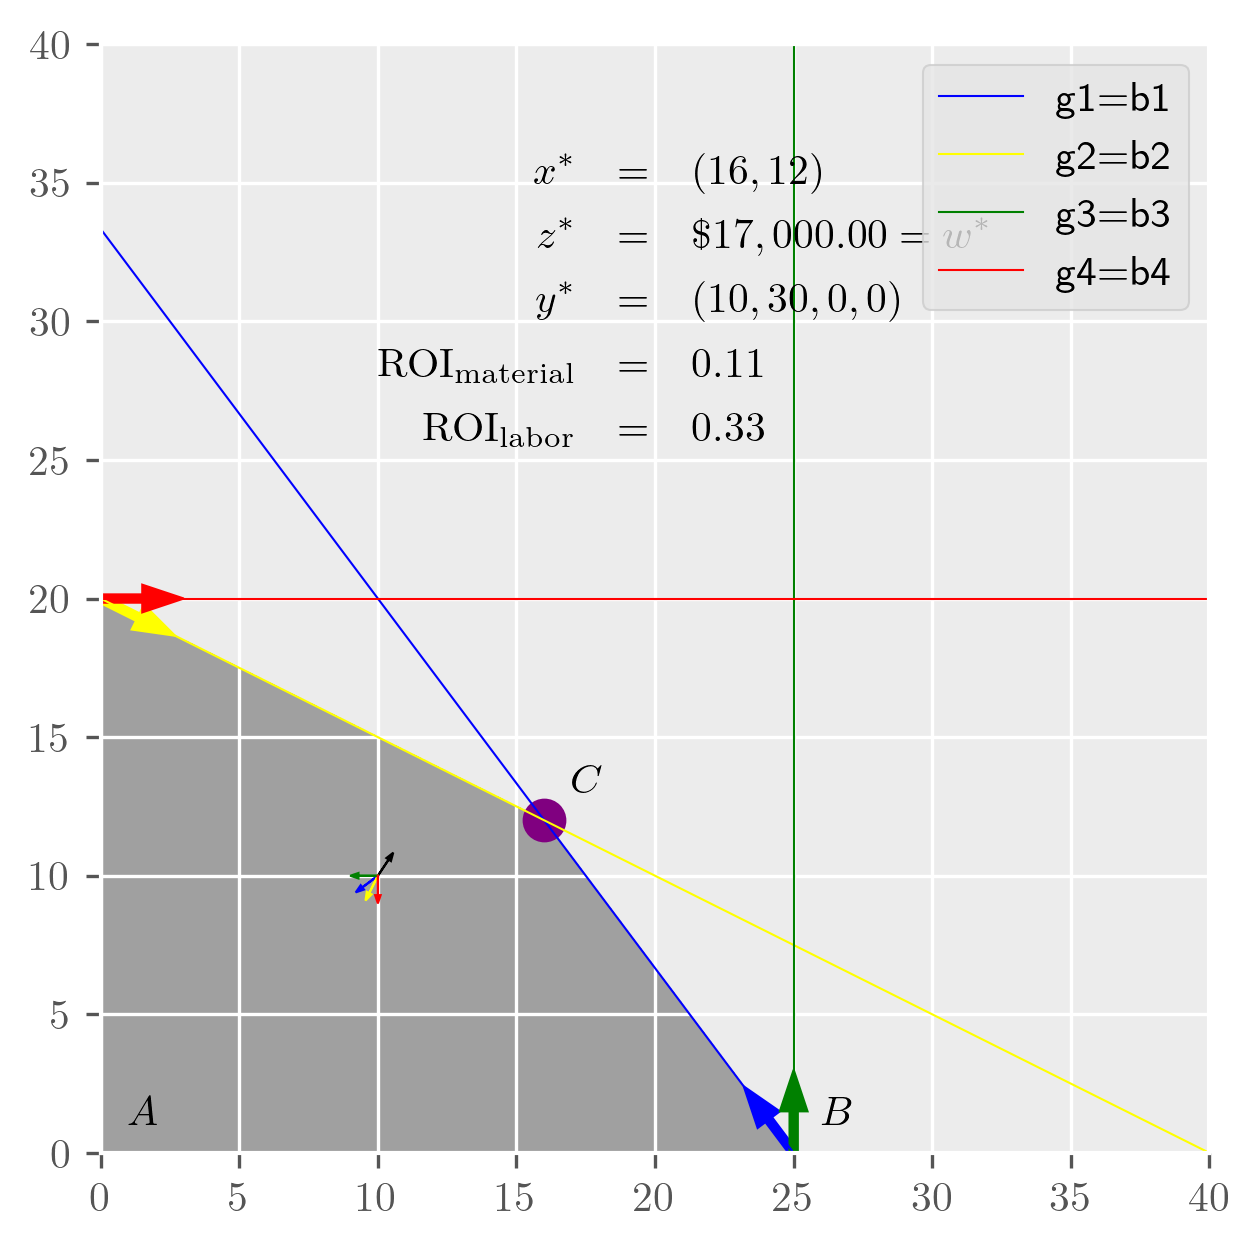

In [492]:
fig=plt.figure(dpi=300);

##########

ax =plt.subplot();
ax.set_aspect(1);

# LINES
ax.plot   (x,y1,label='g1=b1',linewidth=0.5,color='blue');
ax.plot   (x,y2,label='g2=b2',linewidth=0.5,color='yellow');
ax.axvline(  25,label='g3=b3',linewidth=0.5,color='green');
ax.plot   (x,y4,label='g4=b4',linewidth=0.5,color='red');

# DELZ
ax.arrow(10,10,*unitVector(  delz),width=0.01,head_width=0.2,length_includes_head=True,color='black');

# FEASIBLE SIDES <=
ax.arrow(10,10,*unitVector(-delg1),width=0.01,head_width=0.2,length_includes_head=True,color='blue');
ax.arrow(10,10,*unitVector(-delg2),width=0.01,head_width=0.2,length_includes_head=True,color='yellow');
ax.arrow(10,10,*unitVector(-delg3),width=0.01,head_width=0.2,length_includes_head=True,color='green');
ax.arrow(10,10,*unitVector(-delg4),width=0.01,head_width=0.2,length_includes_head=True,color='red');

# DIRECTIONS
ax.arrow(25, 0,*udg1*3,            width=0.3, head_width=1,  length_includes_head=True,color='blue');
ax.arrow( 0,20,*udg2*3,            width=0.3, head_width=1,  length_includes_head=True,color='yellow');
ax.arrow(25, 0,*udg3*3,            width=0.3, head_width=1,  length_includes_head=True,color='green');
ax.arrow( 0,20,*udg4*3,            width=0.3, head_width=1,  length_includes_head=True,color='red');

# FEASIBLE REGION
fx,fy=np.meshgrid(x,x)
plt.imshow(
  (
     (fy<=s1*fx+(100/3))
   & (fy<=s2*fx+( 20/1))
   & (fy<=s4*fx+20     )
  ).astype(int),
  extent=(fx.min(),fx.max(),fy.min(),fy.max()),
  origin='lower',
  cmap  ='Greys',
  alpha =0.3,
);

ax.set_xlim(0,s);
ax.set_ylim(0,s);
ax.legend();

# XSTAR
ax.scatter(*xStar0,s=1e2,color='purple');

sol=(
  r'\begin{eqnarray*}'
  f'x^*&=&{xStar0}'
  r'\\'
  f'z^*&=&\${round(float(zStar0),2):,.2f}=w^*'
  r'\\'
  f'y^*&=&{yStar}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{material}'
  f'&=&{ROI1}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{labor}'
  f'&=&{ROI2}'
  r'\end{eqnarray*}'
)
ax.text(10,35,sol,fontsize=10);

# SIMPLEX
dx,dy=1,1
ax.annotate('$A$',(        0+dx,        0+dy));
ax.annotate('$B$',(       25+dx,        0+dy));
ax.annotate('$C$',(xStar0[0]+dx,xStar0[1]+dy));

---

## [B] Is it profitable for the company to purchase additional material?

$
\begin{aligned}
\text{change in revenue per unit change in material}\,\,\,
\partial z^*&=y_1^*\partial b_1
\impliedby
y_1^*=\frac{\partial z^*}{\partial b_1}
\\
\text{profit}\,\,\,
&=\text{change in revenue}-\text{cost of material}
\\
&=y_1^*\partial b_1-p_1\partial b_1
\\
&=(y_1^*-p_1)\partial b_1
\end{aligned}
$

In [493]:
g2g3  =solve([g2,g3])
xStar1=(g2g3[x1],g2g3[x2])
g1n   =s1*(x1-xStar1[0])+xStar1[1]
b1n   =Fraction(float(g1.subs([(x1,xStar1[0]),(x2,xStar1[1])])+b1)).limit_denominator(2)
db1   =b1n-b1
rc    =p1*db1
zStar1=z.subs([(x1,xStar1[0]),(x2,xStar1[1])])-rc
dzStar=yStar[0]*db1-rc

# db1=symbols('db1')
# solve([
#   g1.subs([(x1,25)])-db1,
#   g2.subs([(x1,25)]),
# ],[db1,x2])

display(Math(
  r"\begin{aligned}"

  r"y_1^*\overset{?}{\gt}p_1&\implies"
  f"{yStar[0]}"
  r"\overset{?}{\gt}"
  f"{p1}"
  r"\\"

  r"g_2=g_3&\implies"
  f"{latex(g2g3)}"
  r"\\"

  r"x^*(\text{new})&="
  f"{xStar1}"
  r"\\"

  r"g_1(\text{new})&="
  f"{latex(nsimplify(g1n))}"
  r"\\"

  r"g_1(\text{new})=x_2&\implies x_1="
  f"{latex(nsimplify(solve([g1n,x2])[x1]))}"
  r"\\"

  r" b_1(\text{new})&="
  f"{b1n}"
  r"\\"

 fr"db_1&={db1}"
  r"&&=b_1(\text{new})-b_1"
  r"\\"

  r"\text{cost}_\text{material}&="
  f"\${rc:,.2f}"
  r"&&=p_1\partial b_1"
  r"\\"

  r"z^*(\text{new})&="
  f"\${zStar1:,.2f}"
  f"&&={latex(z-rc)}"
  r"=w^*\\"

  r"\partial z^*&="
  f"\${dzStar:,.2f}"
  r"&&=y_1^*\partial b_1=z^*(\text{new})-z^*"
  r"\\"

  r"\end{aligned}"
))

<IPython.core.display.Math object>

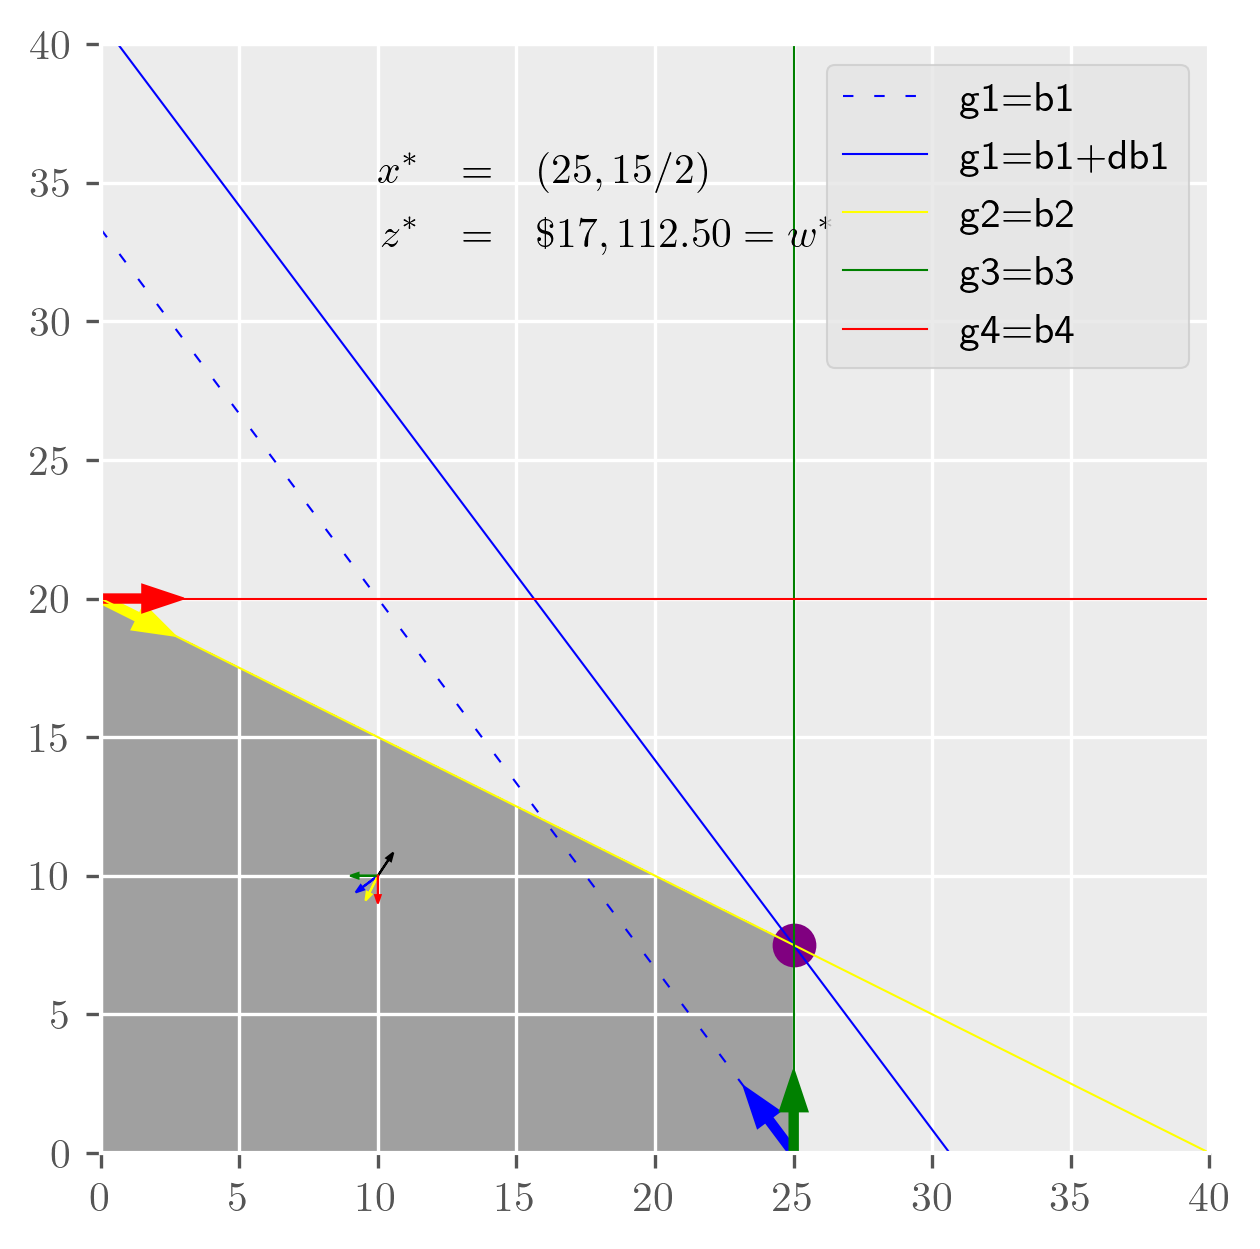

In [494]:
fig=plt.figure(dpi=300);

##########

ax =plt.subplot();
ax.set_aspect(1);

# LINES
ax.plot   (x,y1,                        label='g1=b1',    linewidth=0.5,linestyle=(0,(5,10)),color='blue');
ax.plot   (x,s1*(x-xStar1[0])+xStar1[1],label='g1=b1+db1',linewidth=0.5,                     color='blue');
ax.plot   (x,y2,                        label='g2=b2',    linewidth=0.5,                     color='yellow');
ax.axvline(  25,                        label='g3=b3',    linewidth=0.5,                     color='green');
ax.plot   (x,y4,                        label='g4=b4',    linewidth=0.5,                     color='red');

# DELZ
ax.arrow(10,10,*unitVector(  delz),width=0.01,head_width=0.2,length_includes_head=True,color='black');

# FEASIBLE SIDES <=
ax.arrow(10,10,*unitVector(-delg1),width=0.01,head_width=0.2,length_includes_head=True,color='blue');
ax.arrow(10,10,*unitVector(-delg2),width=0.01,head_width=0.2,length_includes_head=True,color='yellow');
ax.arrow(10,10,*unitVector(-delg3),width=0.01,head_width=0.2,length_includes_head=True,color='green');
ax.arrow(10,10,*unitVector(-delg4),width=0.01,head_width=0.2,length_includes_head=True,color='red');

# DIRECTIONS
ax.arrow(25, 0,*udg1*3,            width=0.3, head_width=1,  length_includes_head=True,color='blue');
ax.arrow( 0,20,*udg2*3,            width=0.3, head_width=1,  length_includes_head=True,color='yellow');
ax.arrow(25, 0,*udg3*3,            width=0.3, head_width=1,  length_includes_head=True,color='green');
ax.arrow( 0,20,*udg4*3,            width=0.3, head_width=1,  length_includes_head=True,color='red');

# FEASIBLE REGION
fx,fy=np.meshgrid(x,x)
plt.imshow(
  (
     (fy<=s1*(fx-float(xStar1[0]))+float(xStar1[1]))
   & (fy<=s2*fx+20)
   & (fx<=25)
   & (fy<= 0*fx+20)
  ).astype(int),
  extent=(fx.min(),fx.max(),fy.min(),fy.max()),
  origin='lower',
  cmap  ='Greys',
  alpha =0.3,
);

ax.set_xlim(0,s);
ax.set_ylim(0,s);
ax.legend();

# XSTAR
ax.scatter(*xStar1,s=1e2,color='purple');

sol=(
  r'\begin{eqnarray*}'
  f'x^*&=&{xStar1}'
  r'\\'
  f'z^*&=&\${round(zStar1,2):,.2f}=w^*'
  r'\\'
  r'\end{eqnarray*}'
)
ax.text(10,35,sol,fontsize=10);

# SIMPLEX
# dx,dy=1,1
# ax.annotate('$A$',(       0+dx,       0+dy));
# ax.annotate('$B$',( (245/8)+dx,       0+dy));
# ax.annotate('$C$',(xStar1[0]+dx,xStar1[1]+dy));

---

## [C] Is it profitable for the company to schedule overtime, having purchased additional material?

In [495]:
d  =d-rc

# CONCISE ROW TABLEAU
rA = Matrix([
  [ 'c', 'x1', 'x2',     1, 'r'],
  ['y1',  -20,  -15,b1+db1,'s1'],
  ['y2',  -10,  -20,b2+db2,'s2'],
  ['y3',   -1,    0,b3+db3,'s3'],
  ['y4',    0,   -1,b4+db4,'s4'],
  [  -1, -500, -750, -d[0],'-z'],
  [ 'c','-v1','-v2',   'w', 'r'],
])
rB = pivot(1,1,rA)
rC = pivot(2,2,rB)
rD = pivot(3,1,rC)

# CONCISE COLUMN TABLEAU
cA = Matrix([
  [ 'c',  'y1',  'y2',  'y3',  'y4',   1, 'r'],
  ['x1',    20,    10,     1,     0,-500,'v1'],
  ['x2',    15,    20,     0,     1,-750,'v2'],
  [  -1,b1+db1,b2+db2,b3+db3,b4+db4,d[0], 'w'],
  [ 'c', '-s1', '-s2', '-s3', '-s4','-z', 'r'],
])
cB = pivot(1,1,cA)
cC = pivot(2,2,cB)
cD = pivot(1,3,cC)

display(Math(
   r'\begin{aligned}'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rA = {latex(rA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rB = {latex(rB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rC = {latex(rC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rD = {latex(rD)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_2=s_3=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cA = {latex(cA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cB = {latex(cB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cC = {latex(cC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cD = {latex(cD)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_2=s_3=0\end{aligned}\\'
   r'\end{aligned}'
))

<IPython.core.display.Math object>

In [496]:
ycStar1=yStar
ydStar1=(0,75/2,125,0)

ROI1c=round((ycStar1[0]-p1)/p1,2)
ROI2c=round((ycStar1[1]-p2)/p2,2)
ROI1d=round((ydStar1[0]-p1)/p1,2)
ROI2d=round((ydStar1[1]-p2)/p2,2)

display(Math(
  r"\begin{aligned}"

  r"x^*&="
  f"{xStar1}"
  r"\\"

  r"z^*&="
  f"\${zStar1:,.2f}"
  f"&&={latex(z-rc)}"
  r"=w^*\\"

  r"yc^*&="
  f"{ycStar1}"
  r"&&=\left(yc_1^*=\frac{\partial z^*}{\partial b_1},yc_2^*=\frac{\partial z^*}{\partial b_2},yc_3^*=\frac{\partial z^*}{\partial b_3},yc_4^*=\frac{\partial z^*}{\partial b_4}\right)"
  r"\\"

  r"\text{ROI}_\text{material}&="
  f"{ROI1c}"
  r"&&=\frac{yc_1^*-p_1}{p_1}"
  r"\\"
  r"\text{ROI}_\text{labor}&="
  f"{ROI2c}"
  r"&&=\frac{yc_2^*-p_2}{p_2}"
  r"\\"

  r"yd^*&="
  f"{ydStar1}"
  r"&&=\left(yd_1^*=\frac{\partial z^*}{\partial b_1},yd_2^*=\frac{\partial z^*}{\partial b_2},yd_3^*=\frac{\partial z^*}{\partial b_3},yd_4^*=\frac{\partial z^*}{\partial b_4}\right)"
  r"\\"

  r"\text{ROI}_\text{material}&="
  f"{ROI1d}"
  r"&&=\frac{yd_1^*-p_1}{p_1}"
  r"\\"
  r"\text{ROI}_\text{labor}&="
  f"{ROI2d}"
  r"&&=\frac{yd_2^*-p_2}{p_2}"
  r"\\"

  r"\end{aligned}"
))

<IPython.core.display.Math object>

In [497]:
g1ng4 =solve([g1n-x2,g4])
#g1ng4=solve([g1-db1,g4])
xStar2=(g1ng4[x1],g1ng4[x2])
g2n   =s2*(x1-xStar2[0])+xStar2[1]
b2n   =float(g2.subs([(x1,xStar2[0]),(x2,xStar2[1])])+b2)
db2   =b2n-b2
rc2   =p2*db2
zStar2=z.subs([(x1,xStar2[0]),(x2,xStar2[1])])-rc2-rc
dzStar=yStar[0]*db2

# db1=symbols('db1')
# solve([
#   g1.subs([(x1,25)])-db1,
#   g2.subs([(x1,25)]),
# ],[db1,x2])

display(Math(
  r"\begin{aligned}"

  r"y_2^*\overset{?}{\gt}p_2&\implies"
  f"{yStar[1]}"
  r"\overset{?}{\gt}"
  f"{p2}"
  r"\\"

  r"g_1(\text{new})=g_4&\implies"
  f"{latex(g1ng4)}"
  r"\\"

  r"x^*(\text{new})&="
  f"{nsimplify(xStar2[0]),nsimplify(xStar2[1])}"
  r"\\"

  r"g_2(\text{new})&="
  f"{latex(nsimplify(g2n))}"
  r"\\"

  r"g_2(\text{new})=x_1&\implies x_1="
  # f"{latex(nsimplify(solve([g2n,x1])[x2]))}"
  r"\\"

  r" b_2(\text{new})&="
  f"{b2n}"
  r"\\"

 fr"db_2&={db2}"
  r"&&=b_2(\text{new})-b_2"
  r"\\"

  r"\text{cost}&="
  f"\${rc2:,.2f}"
  r"&&=p_2\partial b_2"
  r"\\"

  r"z^*(\text{new})&="
  f"\${zStar2:,.2f}"
  f"&&={latex(z-rc2)}"
  r"=w^*\\"

  r"\partial z^*&="
  f"\${dzStar:,.2f}"
  r"&&=y_2^*\partial b_2=z^*(\text{new})-z^*"
  r"\\"

  r"\end{aligned}"
))

<IPython.core.display.Math object>

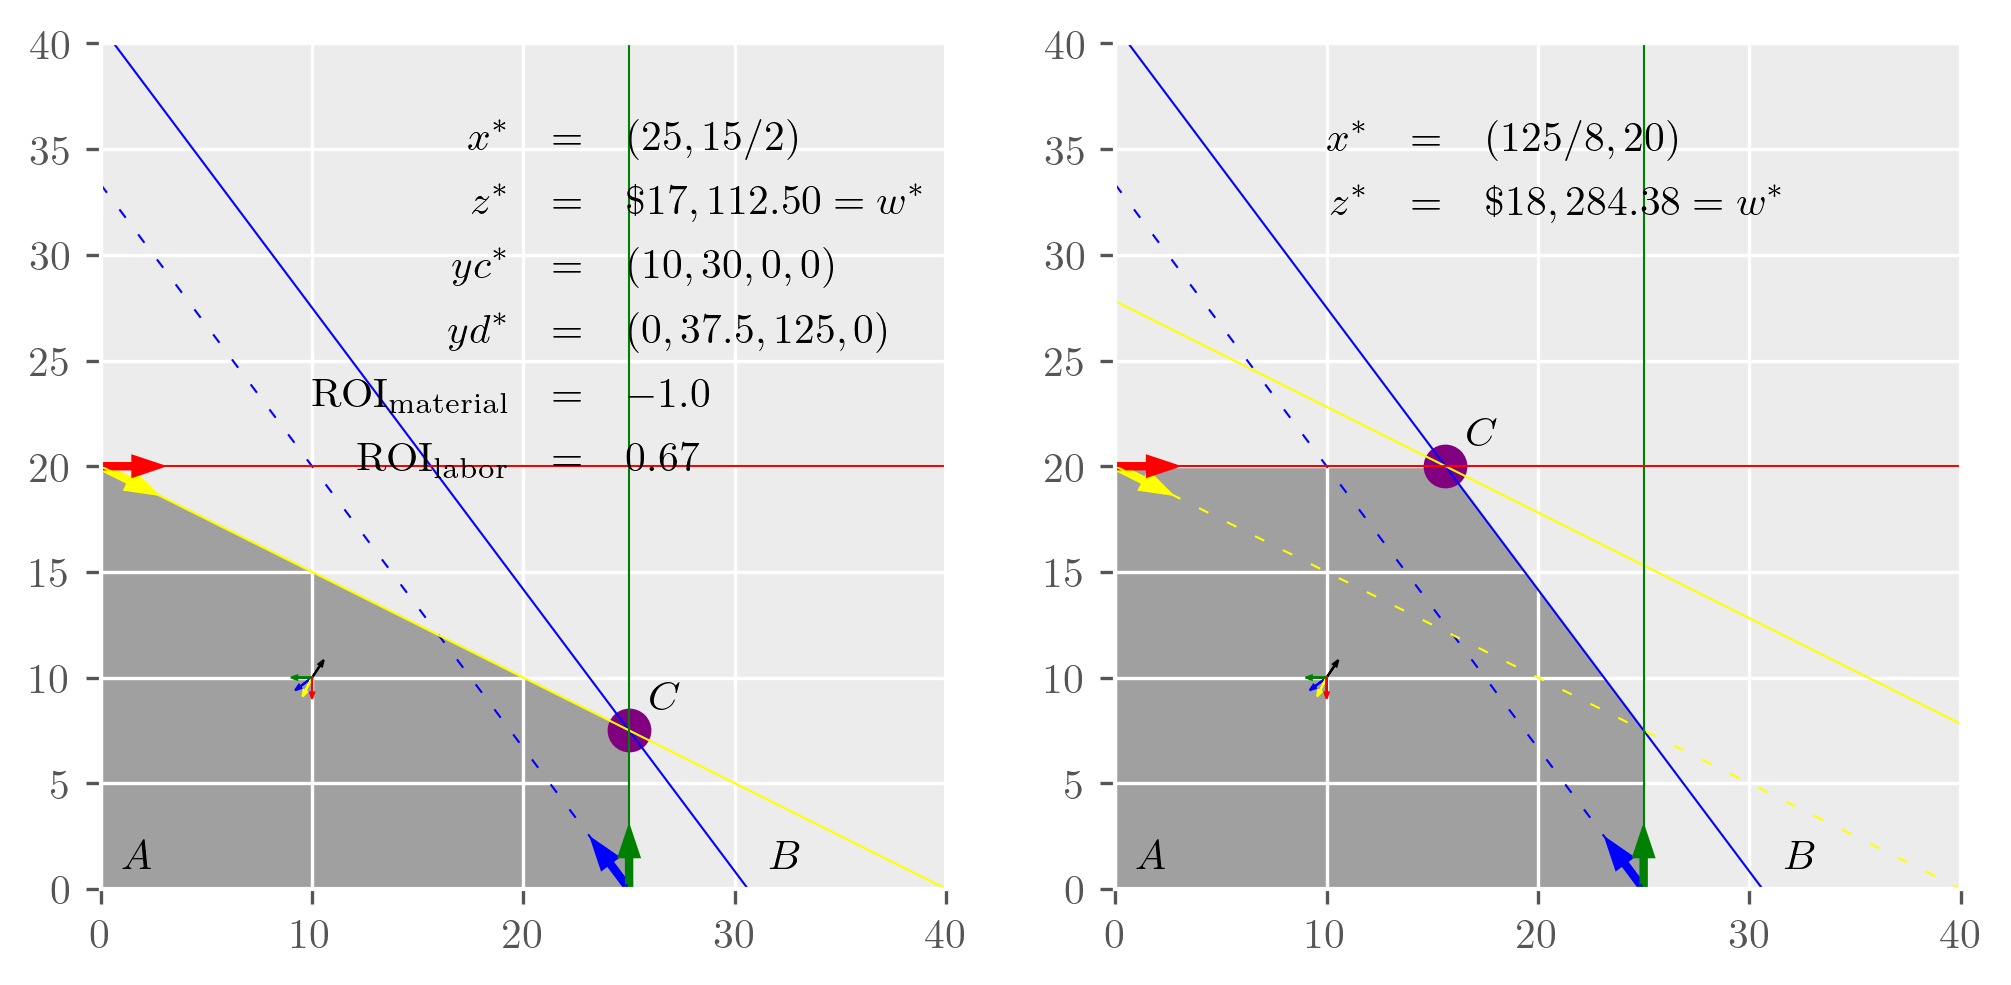

In [498]:
fig=plt.figure(dpi=300,figsize=(8,16));

##########

ax =plt.subplot(121);
ax.set_aspect(1);

# LINES
ax.plot   (x,y1,                        label='g1=b1',    linewidth=0.5,linestyle=(0,(5,10)),color='blue');
ax.plot   (x,s1*(x-xStar1[0])+xStar1[1],label='g1=b1+db1',linewidth=0.5,                     color='blue');
ax.plot   (x,y2,                        label='g2=b2',    linewidth=0.5,                     color='yellow');
ax.axvline(  25,                        label='g3=b3',    linewidth=0.5,                     color='green');
ax.plot   (x,y4,                        label='g4=b4',    linewidth=0.5,                     color='red');

# DELZ
ax.arrow(10,10,*unitVector(  delz),width=0.01,head_width=0.2,length_includes_head=True,color='black');

# FEASIBLE SIDES <=
ax.arrow(10,10,*unitVector(-delg1),width=0.01,head_width=0.2,length_includes_head=True,color='blue');
ax.arrow(10,10,*unitVector(-delg2),width=0.01,head_width=0.2,length_includes_head=True,color='yellow');
ax.arrow(10,10,*unitVector(-delg3),width=0.01,head_width=0.2,length_includes_head=True,color='green');
ax.arrow(10,10,*unitVector(-delg4),width=0.01,head_width=0.2,length_includes_head=True,color='red');

# DIRECTIONS
ax.arrow(25, 0,*udg1*3,            width=0.3, head_width=1,  length_includes_head=True,color='blue');
ax.arrow( 0,20,*udg2*3,            width=0.3, head_width=1,  length_includes_head=True,color='yellow');
ax.arrow(25, 0,*udg3*3,            width=0.3, head_width=1,  length_includes_head=True,color='green');
ax.arrow( 0,20,*udg4*3,            width=0.3, head_width=1,  length_includes_head=True,color='red');

# FEASIBLE REGION
fx,fy=np.meshgrid(x,x)
plt.imshow(
  (
     (fy<=s1*(fx-float(xStar1[0]))+float(xStar1[1]))
   & (fy<=s2*fx+20)
   & (fx<=25)
   & (fy<= 0*fx+20)
  ).astype(int),
  extent=(fx.min(),fx.max(),fy.min(),fy.max()),
  origin='lower',
  cmap  ='Greys',
  alpha =0.3,
);

ax.set_xlim(0,s);
ax.set_ylim(0,s);
#ax.legend();

# XSTAR
ax.scatter(*xStar1,s=1e2,color='purple');

sol=(
  r'\begin{eqnarray*}'
  f'x^*&=&{xStar1}'
  r'\\'
  f'z^*&=&\${round(zStar1,2):,.2f}=w^*'
  r'\\'
  f'yc^*&=&{ycStar1}'
  r'\\'
  f'yd^*&=&{ydStar1}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{material}'
  f'&=&{ROI1d}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{labor}'
  f'&=&{ROI2d}'
  r'\end{eqnarray*}'
)
ax.text(10,35,sol,fontsize=10);

# SIMPLEX
dx,dy=1,1
ax.annotate('$A$',(        0+dx,        0+dy));
ax.annotate('$B$',(  (245/8)+dx,        0+dy));
ax.annotate('$C$',(xStar1[0]+dx,xStar1[1]+dy));

##########

ax2 =plt.subplot(122);
ax2.set_aspect(1);

# LINES
ax2.plot   (x,y1,                        label='g1=b1',    linewidth=0.5,linestyle=(0,(5,10)),color='blue');
ax2.plot   (x,s1*(x-xStar1[0])+xStar1[1],label='g1=b1+db1',linewidth=0.5,                     color='blue');
ax2.plot   (x,y2,                        label='g2=b2',    linewidth=0.5,linestyle=(0,(5,10)),color='yellow');
ax2.plot   (x,s2*(x-xStar2[0])+xStar2[1],label='g2=b2+db2',linewidth=0.5,                     color='yellow');
ax2.axvline(  25,                        label='g3=b3',    linewidth=0.5,                     color='green');
ax2.plot   (x,y4,                        label='g4=b4',    linewidth=0.5,                     color='red');

# DELZ
ax2.arrow(10,10,*unitVector(  delz),width=0.01,head_width=0.2,length_includes_head=True,color='black');

# FEASIBLE SIDES <=
ax2.arrow(10,10,*unitVector(-delg1),width=0.01,head_width=0.2,length_includes_head=True,color='blue');
ax2.arrow(10,10,*unitVector(-delg2),width=0.01,head_width=0.2,length_includes_head=True,color='yellow');
ax2.arrow(10,10,*unitVector(-delg3),width=0.01,head_width=0.2,length_includes_head=True,color='green');
ax2.arrow(10,10,*unitVector(-delg4),width=0.01,head_width=0.2,length_includes_head=True,color='red');

# DIRECTIONS
ax2.arrow(25, 0,*udg1*3,            width=0.3, head_width=1,  length_includes_head=True,color='blue');
ax2.arrow( 0,20,*udg2*3,            width=0.3, head_width=1,  length_includes_head=True,color='yellow');
ax2.arrow(25, 0,*udg3*3,            width=0.3, head_width=1,  length_includes_head=True,color='green');
ax2.arrow( 0,20,*udg4*3,            width=0.3, head_width=1,  length_includes_head=True,color='red');

# FEASIBLE REGION
fx,fy=np.meshgrid(x,x)
plt.imshow(
  (
     (fy<=s1*(fx-float(xStar1[0]))+float(xStar1[1]))
   & (fy<=s2*(fx-float(xStar2[0]))+float(xStar2[1]))
   & (fx<=25)
   & (fy<=0*fx+20)
  ).astype(int),
  extent=(fx.min(),fx.max(),fy.min(),fy.max()),
  origin='lower',
  cmap  ='Greys',
  alpha =0.3,
);

ax2.set_xlim(0,s);
ax2.set_ylim(0,s);
#ax2.legend();

# XSTAR
ax2.scatter(*xStar2,s=1e2,color='purple');

sol=(
  r'\begin{eqnarray*}'
  f'x^*&=&({Fraction(float(xStar2[0])).limit_denominator(10)},{Fraction(float(xStar2[1])).limit_denominator(10)})'
  r'\\'
  f'z^*&=&\${round(zStar2,2):,.2f}=w^*'
  r'\end{eqnarray*}'
)
ax2.text(10,35,sol,fontsize=10);

# SIMPLEX
dx,dy=1,1
ax2.annotate('$A$',(        0+dx,        0+dy));
ax2.annotate('$B$',(  (245/8)+dx,        0+dy));
ax2.annotate('$C$',(xStar2[0]+dx,xStar2[1]+dy));

---

In [499]:
d  =d-rc2

# CONCISE ROW TABLEAU
rA = Matrix([
  [ 'c', 'x1', 'x2',     1, 'r'],
  ['y1',  -20,  -15,b1+db1,'s1'],
  ['y2',  -10,  -20,b2+db2,'s2'],
  ['y3',   -1,    0,b3+db3,'s3'],
  ['y4',    0,   -1,b4+db4,'s4'],
  [  -1, -500, -750, -d[0],'-z'],
  [ 'c','-v1','-v2',   'w', 'r'],
])
rB = pivot(1,1,rA)
rC = pivot(2,2,rB)
rD = pivot(4,2,rC)

# CONCISE COLUMN TABLEAU
cA = Matrix([
  [ 'c',  'y1',  'y2',  'y3',  'y4',   1, 'r'],
  ['x1',    20,    10,     1,     0,-500,'v1'],
  ['x2',    15,    20,     0,     1,-750,'v2'],
  [  -1,b1+db1,b2+db2,b3+db3,b4+db4,d[0], 'w'],
  [ 'c', '-s1', '-s2', '-s3', '-s4','-z', 'r'],
])
cB = pivot(1,1,cA)
cC = pivot(2,2,cB)
cD = pivot(2,4,cC)

display(Math(
   r'\begin{aligned}'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rA = {latex(rA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rB = {latex(rB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rC = {latex(rC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rD = {latex(rD)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_1=s_4=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cA = {latex(cA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cB = {latex(cB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cC = {latex(cC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cD = {latex(cD)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_1=s_4=0\end{aligned}\\'
   r'\end{aligned}'
))

<IPython.core.display.Math object>

In [500]:
ycStar2=yStar
ydStar2=(25,0,0,375)

ROI3c=round((ycStar2[0]-p1)/p1,2)
ROI4c=round((ycStar2[1]-p2)/p2,2)
ROI3d=round((ydStar2[0]-p1)/p1,2)
ROI4d=round((ydStar2[1]-p2)/p2,2)

display(Math(
  r"\begin{aligned}"

  r"x^*&="
  f"({Fraction(float(xStar2[0])).limit_denominator(10)},{Fraction(float(xStar2[1])).limit_denominator(10)})"
  r"\\"

  r"z^*&="
  f"\${zStar2:,.2f}"
  f"&&={latex(z-rc2-rc)}"
  r"=w^*\\"

  r"yc^*&="
  f"{ycStar2}"
  r"\\"

  r"\text{ROI}_\text{material}&="
  f"{ROI3c}"
  r"&&=\frac{yc_1^*-p_1}{p_1}"
  r"\\"
  r"\text{ROI}_\text{labor}&="
  f"{ROI4c}"
  r"&&=\frac{yc_2^*-p_2}{p_2}"
  r"\\"

  r"yd^*&="
  f"{ydStar2}"
  r"\\"

  r"\text{ROI}_\text{material}&="
  f"{ROI3d}"
  r"&&=\frac{yd_1^*-p_1}{p_1}"
  r"\\"
  r"\text{ROI}_\text{labor}&="
  f"{ROI4d}"
  r"&&=\frac{yd_2^*-p_2}{p_2}"
  r"\\"

  r"\end{aligned}"
))

<IPython.core.display.Math object>

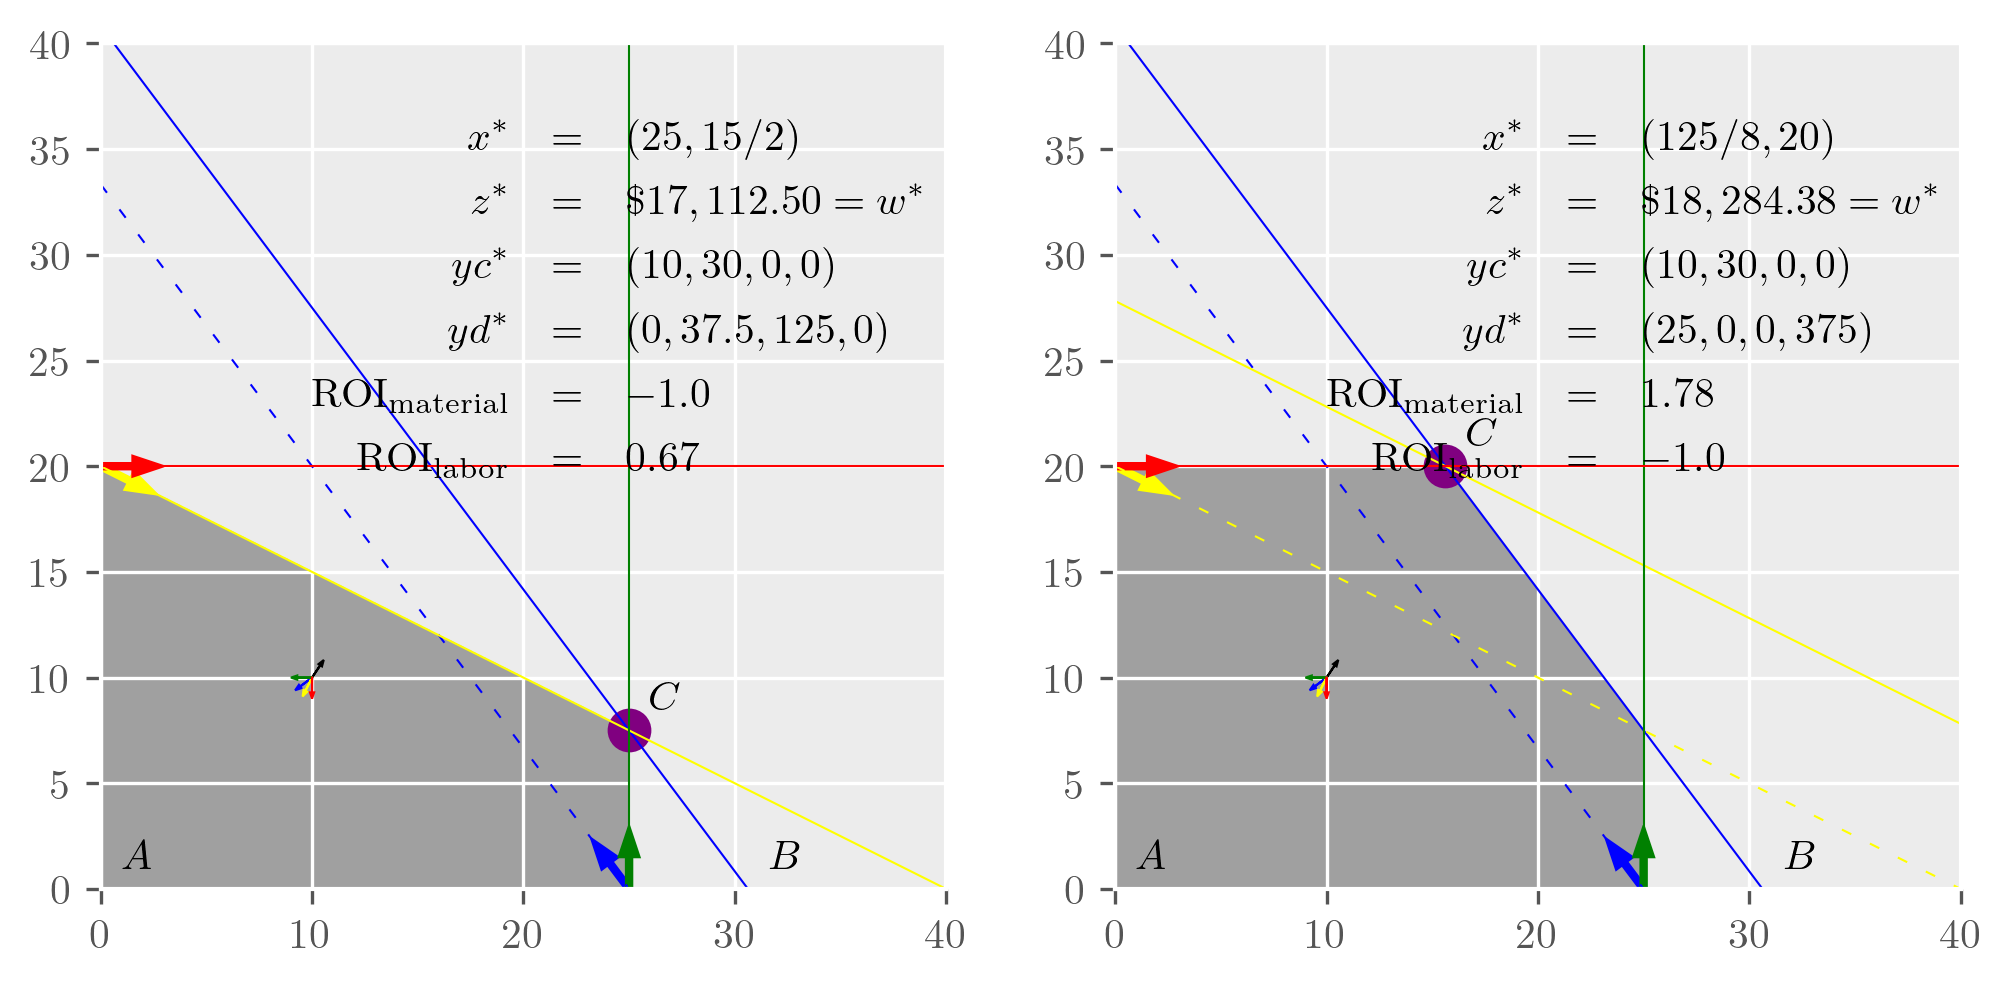

In [501]:
fig=plt.figure(dpi=300,figsize=(8,16));

##########

ax =plt.subplot(121);
ax.set_aspect(1);

# LINES
ax.plot   (x,y1,                        label='g1=b1',    linewidth=0.5,linestyle=(0,(5,10)),color='blue');
ax.plot   (x,s1*(x-xStar1[0])+xStar1[1],label='g1=b1+db1',linewidth=0.5,                     color='blue');
ax.plot   (x,y2,                        label='g2=b2',    linewidth=0.5,                     color='yellow');
ax.axvline(  25,                        label='g3=b3',    linewidth=0.5,                     color='green');
ax.plot   (x,y4,                        label='g4=b4',    linewidth=0.5,                     color='red');

# DELZ
ax.arrow(10,10,*unitVector(  delz),width=0.01,head_width=0.2,length_includes_head=True,color='black');

# FEASIBLE SIDES <=
ax.arrow(10,10,*unitVector(-delg1),width=0.01,head_width=0.2,length_includes_head=True,color='blue');
ax.arrow(10,10,*unitVector(-delg2),width=0.01,head_width=0.2,length_includes_head=True,color='yellow');
ax.arrow(10,10,*unitVector(-delg3),width=0.01,head_width=0.2,length_includes_head=True,color='green');
ax.arrow(10,10,*unitVector(-delg4),width=0.01,head_width=0.2,length_includes_head=True,color='red');

# DIRECTIONS
ax.arrow(25, 0,*udg1*3,            width=0.3, head_width=1,  length_includes_head=True,color='blue');
ax.arrow( 0,20,*udg2*3,            width=0.3, head_width=1,  length_includes_head=True,color='yellow');
ax.arrow(25, 0,*udg3*3,            width=0.3, head_width=1,  length_includes_head=True,color='green');
ax.arrow( 0,20,*udg4*3,            width=0.3, head_width=1,  length_includes_head=True,color='red');

# FEASIBLE REGION
fx,fy=np.meshgrid(x,x)
plt.imshow(
  (
     (fy<=s1*(fx-float(xStar1[0]))+float(xStar1[1]))
   & (fy<=s2*fx+20)
   & (fx<=25)
   & (fy<= 0*fx+20)
  ).astype(int),
  extent=(fx.min(),fx.max(),fy.min(),fy.max()),
  origin='lower',
  cmap  ='Greys',
  alpha =0.3,
);

ax.set_xlim(0,s);
ax.set_ylim(0,s);
#ax.legend();

# XSTAR
ax.scatter(*xStar1,s=1e2,color='purple');

sol=(
  r'\begin{eqnarray*}'
  f'x^*&=&{xStar1}'
  r'\\'
  f'z^*&=&\${round(zStar1,2):,.2f}=w^*'
  r'\\'
  f'yc^*&=&{ycStar1}'
  r'\\'
  f'yd^*&=&{ydStar1}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{material}'
  f'&=&{ROI1d}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{labor}'
  f'&=&{ROI2d}'
  r'\end{eqnarray*}'
)
ax.text(10,35,sol,fontsize=10);

# SIMPLEX
dx,dy=1,1
ax.annotate('$A$',(        0+dx,        0+dy));
ax.annotate('$B$',(  (245/8)+dx,        0+dy));
ax.annotate('$C$',(xStar1[0]+dx,xStar1[1]+dy));

##########

ax2 =plt.subplot(122);
ax2.set_aspect(1);

# LINES
ax2.plot   (x,y1,                        label='g1=b1',    linewidth=0.5,linestyle=(0,(5,10)),color='blue');
ax2.plot   (x,s1*(x-xStar1[0])+xStar1[1],label='g1=b1+db1',linewidth=0.5,                     color='blue');
ax2.plot   (x,y2,                        label='g2=b2',    linewidth=0.5,linestyle=(0,(5,10)),color='yellow');
ax2.plot   (x,s2*(x-xStar2[0])+xStar2[1],label='g2=b2+db2',linewidth=0.5,                     color='yellow');
ax2.axvline(  25,                        label='g3=b3',    linewidth=0.5,                     color='green');
ax2.plot   (x,y4,                        label='g4=b4',    linewidth=0.5,                     color='red');

# DELZ
ax2.arrow(10,10,*unitVector(  delz),width=0.01,head_width=0.2,length_includes_head=True,color='black');

# FEASIBLE SIDES <=
ax2.arrow(10,10,*unitVector(-delg1),width=0.01,head_width=0.2,length_includes_head=True,color='blue');
ax2.arrow(10,10,*unitVector(-delg2),width=0.01,head_width=0.2,length_includes_head=True,color='yellow');
ax2.arrow(10,10,*unitVector(-delg3),width=0.01,head_width=0.2,length_includes_head=True,color='green');
ax2.arrow(10,10,*unitVector(-delg4),width=0.01,head_width=0.2,length_includes_head=True,color='red');

# DIRECTIONS
ax2.arrow(25, 0,*udg1*3,            width=0.3, head_width=1,  length_includes_head=True,color='blue');
ax2.arrow( 0,20,*udg2*3,            width=0.3, head_width=1,  length_includes_head=True,color='yellow');
ax2.arrow(25, 0,*udg3*3,            width=0.3, head_width=1,  length_includes_head=True,color='green');
ax2.arrow( 0,20,*udg4*3,            width=0.3, head_width=1,  length_includes_head=True,color='red');

# FEASIBLE REGION
fx,fy=np.meshgrid(x,x)
plt.imshow(
  (
     (fy<=s1*(fx-float(xStar1[0]))+float(xStar1[1]))
   & (fy<=s2*(fx-float(xStar2[0]))+float(xStar2[1]))
   & (fx<=25)
   & (fy<=0*fx+20)
  ).astype(int),
  extent=(fx.min(),fx.max(),fy.min(),fy.max()),
  origin='lower',
  cmap  ='Greys',
  alpha =0.3,
);

ax2.set_xlim(0,s);
ax2.set_ylim(0,s);
#ax2.legend();

# XSTAR
ax2.scatter(*xStar2,s=1e2,color='purple');

sol=(
  r'\begin{eqnarray*}'
  f'x^*&=&({Fraction(float(xStar2[0])).limit_denominator(10)},{Fraction(float(xStar2[1])).limit_denominator(10)})'
  r'\\'
  f'z^*&=&\${round(zStar2,2):,.2f}=w^*'
  r'\\'
  f'yc^*&=&{ycStar2}'
  r'\\'
  f'yd^*&=&{ydStar2}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{material}'
  f'&=&{ROI3d}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{labor}'
  f'&=&{ROI4d}'
  r'\end{eqnarray*}'
)
ax2.text(10,35,sol,fontsize=10);

# SIMPLEX
dx,dy=1,1
ax2.annotate('$A$',(        0+dx,        0+dy));
ax2.annotate('$B$',(  (245/8)+dx,        0+dy));
ax2.annotate('$C$',(xStar2[0]+dx,xStar2[1]+dy));

---

## [D] How much additional capital does the company need to maximize profit?

In [502]:
xStar4=(25,20)
db1   =g1.subs([(x1,xStar4[0]),(x2,xStar4[1])])
db2   =g2.subs([(x1,xStar4[0]),(x2,xStar4[1])])
rc4   =p1*db1+p2*db2
zStar4=z.subs([(x1,xStar4[0]),(x2,xStar4[1])])

display(Math(
  r"\begin{aligned}"

  f"g_1(25,20)&={latex(db1+b1)}"
  r"\,\,\,\text{hrs total}"
  r"\\"
  f"g_2(25,20)&={latex(g2.subs([(x1,25),(x2,20)])+b2)}"
  r"\,\,\,\text{lbs total}"
  r"\\"
  f"g_1(25,20)-b_1&={latex(db1)}"
  r"\,\,\,\text{hrs additional}"
  r"\\"
  f"g_2(25,20)-b_2&={latex(db2)}"
  r"\,\,\,\text{lbs additional}"
  r"\\"
  r"\text{cost of additional material and labor}&="
  f"\${rc4:,.2f}"
  r"\\"

  r"z^*"
  f"{xStar4}"
  r"&="
  f"\${zStar4-rc4:,.2f}"

  r"\end{aligned}"
))

<IPython.core.display.Math object>

In [503]:
d  =np.array([-rc4])

# CONCISE ROW TABLEAU
rA = Matrix([
  [ 'c', 'x1',  'x2',     1, 'r'],
  ['y1',  -20,   -15,b1+db1,'s1'],
  ['y2',  -10,   -20,b2+db2,'s2'],
  ['y3',   -1,     0,b3+db3,'s3'],
  ['y4',    0,    -1,b4+db4,'s4'],
  [  -1, -500,  -750, -d[0],'-z'],
  [ 'c','-v1', '-v2',   'w', 'r'],
])
rB = pivot(1,1,rA)
rC = pivot(2,2,rB)
rD = pivot(4,2,rC)
rE = pivot(3,1,rD)

# CONCISE COLUMN TABLEAU
cA = Matrix([
  [ 'c',  'y1',  'y2',  'y3',  'y4',   1, 'r'],
  ['x1',    20,    10,     1,     0,-500,'v1'],
  ['x2',    15,    20,     0,     1,-750,'v2'],
  [  -1,b1+db1,b2+db2,b3+db3,b4+db4,d[0], 'w'],
  [ 'c', '-s1', '-s2', '-s3', '-s4','-z', 'r'],
])
cB = pivot(1,1,cA)
cC = pivot(2,2,cB)
cD = pivot(2,4,cC)
cE = pivot(1,3,cD)

display(Math(
   r'\begin{aligned}'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rA = {latex(rA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rB = {latex(rB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rC = {latex(rC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rD = {latex(rD)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_1=s_4=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rE = {latex(rE)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_3=s_4=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cA = {latex(cA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cB = {latex(cB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cC = {latex(cC)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&s_1=s_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cD = {latex(cD)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_1=s_4=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cE = {latex(cE)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{LEVEL SET}\\&s_3=s_4=0\end{aligned}\\'
   r'\end{aligned}'
))

<IPython.core.display.Math object>

In [504]:
ycStar4=yStar
ydStar4=(25,0,0,375)
yeStar4=(0,0,500,750)

ROI5c=round((ycStar4[0]-p1)/p1,2)
ROI6c=round((ycStar4[1]-p2)/p2,2)
ROI5d=round((ydStar4[0]-p1)/p1,2)
ROI6d=round((ydStar4[1]-p2)/p2,2)
ROI5e=round((yeStar4[0]-p1)/p1,2)
ROI6e=round((yeStar4[1]-p2)/p2,2)

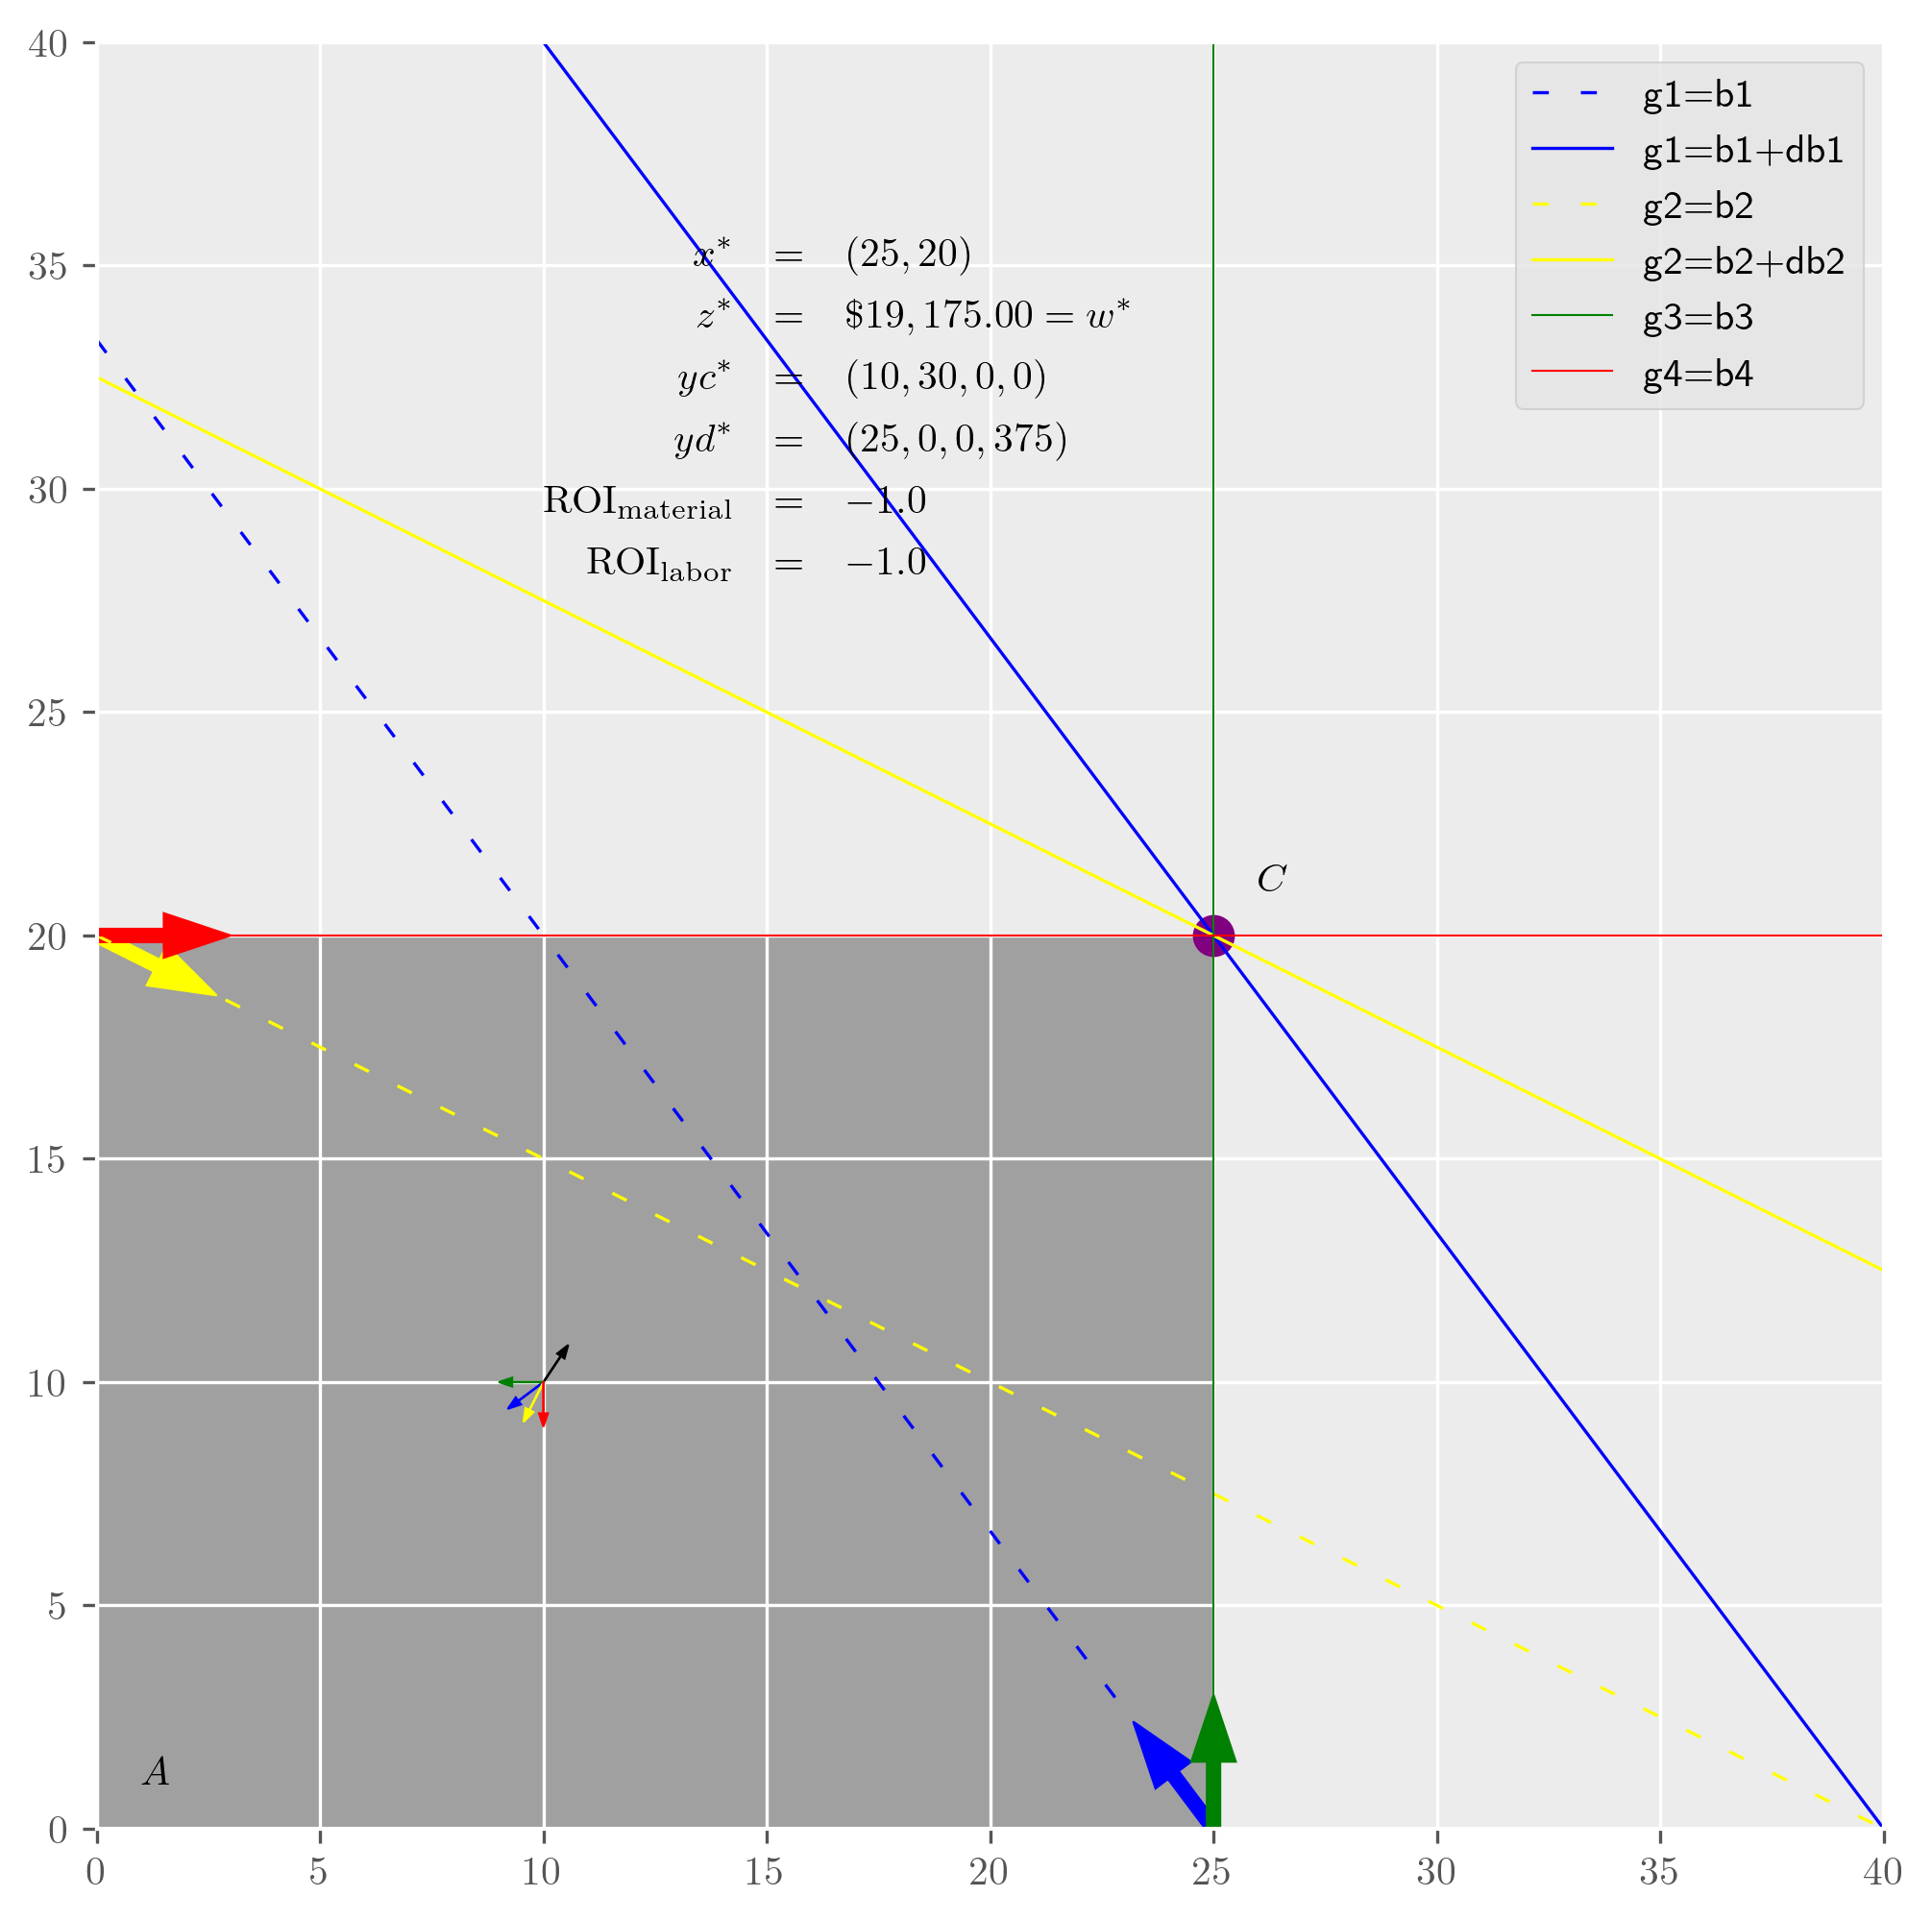

In [505]:
fig=plt.figure(dpi=300,figsize=(8,16));

##########

ax2 =plt.subplot();
ax2.set_aspect(1);

# LINES
ax2.plot   (x,y1,                        label='g1=b1',    linewidth=0.8,linestyle=(0,(5,10)),color='blue');
ax2.plot   (x,s1*(x-xStar4[0])+xStar4[1],label='g1=b1+db1',linewidth=0.8,                     color='blue');
ax2.plot   (x,y2,                        label='g2=b2',    linewidth=0.8,linestyle=(0,(5,10)),color='yellow');
ax2.plot   (x,s2*(x-xStar4[0])+xStar4[1],label='g2=b2+db2',linewidth=0.8,                     color='yellow');
ax2.axvline(  25,                        label='g3=b3',    linewidth=0.5,                     color='green');
ax2.plot   (x,y4,                        label='g4=b4',    linewidth=0.5,                     color='red');

# DELZ
ax2.arrow(10,10,*unitVector(  delz),width=0.01,head_width=0.2,length_includes_head=True,color='black');

# FEASIBLE SIDES <=
ax2.arrow(10,10,*unitVector(-delg1),width=0.01,head_width=0.2,length_includes_head=True,color='blue');
ax2.arrow(10,10,*unitVector(-delg2),width=0.01,head_width=0.2,length_includes_head=True,color='yellow');
ax2.arrow(10,10,*unitVector(-delg3),width=0.01,head_width=0.2,length_includes_head=True,color='green');
ax2.arrow(10,10,*unitVector(-delg4),width=0.01,head_width=0.2,length_includes_head=True,color='red');

# DIRECTIONS
ax2.arrow(25, 0,*udg1*3,            width=0.3, head_width=1,  length_includes_head=True,color='blue');
ax2.arrow( 0,20,*udg2*3,            width=0.3, head_width=1,  length_includes_head=True,color='yellow');
ax2.arrow(25, 0,*udg3*3,            width=0.3, head_width=1,  length_includes_head=True,color='green');
ax2.arrow( 0,20,*udg4*3,            width=0.3, head_width=1,  length_includes_head=True,color='red');

# FEASIBLE REGION
fx,fy=np.meshgrid(x,x)
plt.imshow(
  (
     (fy<=s1*(fx-float(xStar4[0]))+float(xStar4[1]))
   & (fy<=s2*(fx-float(xStar4[0]))+float(xStar4[1]))
   & (fx<=25)
   & (fy<=0*fx+20)
  ).astype(int),
  extent=(fx.min(),fx.max(),fy.min(),fy.max()),
  origin='lower',
  cmap  ='Greys',
  alpha =0.3,
);

ax2.set_xlim(0,s);
ax2.set_ylim(0,s);
ax2.legend();

# XSTAR
ax2.scatter(*xStar4,s=1e2,color='purple');

sol=(
  r'\begin{eqnarray*}'
  f'x^*&=&({Fraction(float(xStar4[0])).limit_denominator(10)},{Fraction(float(xStar4[1])).limit_denominator(10)})'
  r'\\'
  f'z^*&=&\${round(zStar4-rc4,2):,.2f}=w^*'
  r'\\'
  f'yc^*&=&{ycStar4}'
  r'\\'
  f'yd^*&=&{ydStar4}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{material}'
  f'&=&{ROI5e}'
  r'\\'
  r'\mathrm{ROI}_\mathrm{labor}'
  f'&=&{ROI6e}'
  r'\end{eqnarray*}'
)
ax2.text(10,35,sol,fontsize=10);

# SIMPLEX
dx,dy=1,1
ax2.annotate('$A$',(        0+dx,        0+dy));
ax2.annotate('$B$',(       40+dx,        0+dy));
ax2.annotate('$C$',(xStar4[0]+dx,xStar4[1]+dy));

---

## [E] If the company only has $5,000.00 in capital for the purposes of increasing production (and not the amount determined to meet demand in [D]), what allocation of overtime and additional material maximizes the company's profit?

In [506]:
display(Math(
  r"\begin{aligned}"
  r"\text{ROI}_\text{material}&="
  f"{ROI1}"
  r"&&\text{return on investment per dollar invested in material}"
  r"\\"
  r"\text{ROI}_\text{labor}&="
  f"{ROI2}"
  r"&&\text{return on investment per dollar invested in labor}"
  r"\\"
  r"\end{aligned}"
))

<IPython.core.display.Math object>

Both purchasing additional material and scheduling overtime are profitable, but the limited budget constrains us to make certain considerations.

Scheduling overtime is more profitable than purchasing additional material since the return on its investment is higher.

Make the additional material purchased [db1=x3] and overtime schedule [db2=x4] new control variables.

$
\begin{aligned}
g_i\le b_i+db_i
&\iff
g_i-db_i\le b_i
\\
g_1\le b_1+db_1
&\iff
g_1-db_1\le b_1
\implies
g_1-x_3\le b_1
\\
g_2\le b_2+db_2
&\iff
g_2-db_2\le b_2
\implies
g_2-x_4\le b_2
\end{aligned}
$

$
\begin{aligned}
\max z(\mathbf{x})&=500x_1+750x_2-(9.00x_3+22.50x_4)
\\
g_1(\mathbf{x})&=20x_1+15x_2-x_3\le500=b_1
&&\text{material constraint}
\\
g_2(\mathbf{x})&=10x_1+20x_2-x_4\le400=b_2
&&\text{labor constraint}
\\
g_3(\mathbf{x})&=x_1\le25=b_3
&&\text{Type A valve demand constaint}
\\
g_4(\mathbf{x})&=x_2\le20=b_4
&&\text{Type B valve demand constraint}
\\
g_5(\mathbf{x})&=9.00x_3+22.50x_4\le5000=b_5
&&\text{budget constraint}
\\
\mathbf{x}&\ge\mathbf{0}
&&\text{no negative production}
\end{aligned}
$

    LP          A       B
    max z = 500x1 + 750x2 - (9.00x3 + 22.50x4)
       g1 =  20x1 +  15x2 -     1x3 +     0x4  <=  500 = b1   material            constraint
       g2 =  10x1 +  20x2       0x3 -     1x4  <=  400 = b2   labor               constraint
       g3 =   1x1 +   0x2 +     0x3 +     0x4  <=   25 = b3   Type A valve demand constraint
       g4 =   0x1 +   1x2 +     0x3 +     0x4  <=   20 = b4   Type B valve demand constraint
       g5 =   0x1 +   0x2 +  9.00x3 + 22.50x4  <= 5000 = b5   budget              constraint
                                             x >= 0           no negative production

In [507]:
d =   0
b1= 500
b2= 400
b3=  25
b4=  20
b5=5000

z =500*x1+750*x2-9*x3-(45/2)*x4- d
g1= 20*x1+ 15*x2  -x3        -b1
g2= 10*x1+ 20*x2          -x4-b2
g3=  1*x1+  0*x2             -b3
g4=  0*x1+  1*x2             -b4
g5=              9*x3+(45/2)*x4-b5

db1=0
db2=0
db3=0
db4=0
db5=0

In [508]:
A=np.array([[20,15,-1,0],[10,20,0,-1],[1,0,0,0],[0,1,0,0],[0,0,9,(45/2)]])
b=np.array([500,400,25,20,5000])
c=np.array([500,750,-9,-(45/2)])
d=np.array([0])
x=np.array([x1,x2,x3,x4])

display(Math(
   r"\begin{aligned}"
  fr"  z&={latex( c@x+d [0])}\\"
  fr"g_1&={latex((A@x-b)[0])}\\"
  fr"g_2&={latex((A@x-b)[1])}\\"
  fr"g_3&={latex((A@x-b)[2])}\\"
  fr"g_4&={latex((A@x-b)[3])}\\"
  fr"g_5&={latex((A@x-b)[4])}\\"
   r"\end{aligned}"),
)

<IPython.core.display.Math object>

In [509]:
# CONCISE ROW TABLEAU
rA = Matrix([
  [ 'c', 'x1', 'x2', 'x3',   'x4',      1, 'r'],
  ['y1',  -20,  -15,    1,      0, b1+db1,'s1'],
  ['y2',  -10,  -20,    0,      1, b2+db2,'s2'],
  ['y3',   -1,    0,    0,      0, b3+db3,'s3'],
  ['y4',    0,   -1,    0,      0, b4+db4,'s4'],
  ['y5',    0,    0,   -9,-(45/2), b5+db5,'s5'],
  [  -1, -500, -750,    9, (45/2),  -d[0],'-z'],
  [ 'c','-v1','-v2','-v3',  '-v4',    'w', 'r'],
])
rB = pivot(1,1,rA)
rC = pivot(2,2,rB)
rD = pivot(3,3,rC)
rE = pivot(5,4,rD)
rF = pivot(4,3,rE)

# CONCISE COLUMN TABLEAU
cA = Matrix([
  [ 'c',  'y1',  'y2',  'y3',  'y4',  'y5',     1, 'r'],
  ['x1',    20,    10,     1,     0,     0,  -500,'v1'],
  ['x2',    15,    20,     0,     1,     0,  -750,'v2'],
  ['x3',    -1,     0,     0,     0,     9,     9,'v3'],
  ['x4',     0,    -1,     0,     0,(45/2),(45/2),'v4'],
  [  -1,b1+db1,b2+db2,b3+db3,b4+db4,b5+db5,  d[0], 'w'],
  [ 'c', '-s1', '-s2', '-s3', '-s4', '-s5',  '-z', 'r'],
])
cB = pivot(1,1,cA)
cC = pivot(2,2,cB)
cD = pivot(3,3,cC)
cE = pivot(4,5,cD)
cF = pivot(3,4,cE)

display(Math(
   r'\begin{aligned}'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rA = {latex(rA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rB = {latex(rB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rC = {latex(rC)}\,\,\,\,\,&&s_1=s_2=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rD = {latex(rD)}\,\,\,\,\,&&\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rE = {latex(nsimplify(rE))}\,\,\,\,\,&&\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,rF = {latex(nsimplify(rF))}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cA = {latex(cA)}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{START}\\&x_1=x_2=0\end{aligned}\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cB = {latex(cB)}\,\,\,\,\,&&x_2=s_1=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cC = {latex(cC)}\,\,\,\,\,&&s_1=s_2=0\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cD = {latex(cD)}\,\,\,\,\,&&\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cE = {latex(nsimplify(cE))}\,\,\,\,\,&&\\'
  fr'db &= ({db1},{db2},{db3},{db4})\,\,\,cF = {latex(nsimplify(cF))}\,\,\,\,\,&&'
   r'\begin{aligned}&\text{OPTIMAL}\\&\end{aligned}\\'
   r'\end{aligned}'
))

<IPython.core.display.Math object>

In [510]:
cF[-2,-2]

----